<a href="https://colab.research.google.com/github/samuel-gerstein/gridworld-RL/blob/main/Gridworld_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Three Algorithms:


*   Q-Learning
*   Double Q-Learning
*   SARSA(λ)







# Creating Gridworld using OpenAI Gym

In [ ]:
import gym
import random
import numpy as np
import statistics

In [ ]:
custom_map = [
    'SFF', #S is initial point of agent
    'FFF', #F is safe frozen ice
    'FFG'  #G is goal (reward = 1)
]

In [ ]:
env = gym.make("FrozenLake-v0", is_slippery = False, desc = custom_map).env
env.reset()
env.render()


SFF
FFF
FFG


Action Mapping:
*   0 - Left
*   1 - Down
*   2 - Right
*   3 - Up

In [ ]:
#Ground Truth V-Table for gamma = 0.8
true_v = np.array([0.512, 0.64   , 0.512   , 0.64 , 0.8   , 0.64   , 0.8  , 1.   , 0.   ])
true_v.reshape((3,3))

#Need to calculate q table by hand because some states go unexplored

array([[0.512, 0.64 , 0.512],
       [0.64 , 0.8  , 0.64 ],
       [0.8  , 1.   , 0.   ]])

# Q-Learning

In [ ]:
def q_learning(env, epochs, alpha, epsilon, gamma):
  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  v_table = np.zeros(env.observation_space.n)
  steps_to_goal = []
  sum_squared_error = []
  for i in range (0,epochs):
    v_error = []
    state = env.reset()
    done = False
    steps = 0 
    while not done:
      if np.random.random() < epsilon:  #Epsilon Greedy Action
        action = env.action_space.sample()
      else:
        action = np.argmax(q_table[state])
      
      next_state, reward, done, info = env.step(action)
      
      old_q = q_table[state, action]
      next_q = np.max(q_table[next_state])

      updated_q = (1 - alpha) * old_q + alpha * (reward + gamma * next_q) #TD Step
      q_table[state, action] = updated_q

      v_table[state] = reward + gamma * v_table[next_state] #Bellman Equation for V

      state = next_state
      steps += 1
    steps_to_goal.append(steps)
    
    zip_object = zip(true_v, v_table)
    for v_true, v_current in zip_object:
      v_error.append(v_current - v_true)  #Change in V
    v_error = np.square(v_error)
    v_error = np.sum(v_error)
    sum_squared_error.append(v_error)
  return(sum_squared_error, steps_to_goal, v_table)

In [ ]:
alpha = 1
gamma = 0.8
epsilon = 0.01

In [ ]:
q_mse = []
q_avg_steps = []
q_v_table = []

In [ ]:
for i in range(0,100):
  print("-------- Starting Round: ", (i+1))
  sum_squared_error, steps_to_goal, v_table = q_learning(env, 100, alpha, epsilon, gamma)
  q_mse.append(sum_squared_error)
  q_avg_steps.append(steps_to_goal)
  q_v_table.append(v_table)

-------- Starting Round:  1
-------- Starting Round:  2
-------- Starting Round:  3
-------- Starting Round:  4
-------- Starting Round:  5
-------- Starting Round:  6
-------- Starting Round:  7
-------- Starting Round:  8
-------- Starting Round:  9
-------- Starting Round:  10
-------- Starting Round:  11
-------- Starting Round:  12
-------- Starting Round:  13
-------- Starting Round:  14
-------- Starting Round:  15
-------- Starting Round:  16
-------- Starting Round:  17
-------- Starting Round:  18
-------- Starting Round:  19
-------- Starting Round:  20
-------- Starting Round:  21
-------- Starting Round:  22
-------- Starting Round:  23
-------- Starting Round:  24
-------- Starting Round:  25
-------- Starting Round:  26
-------- Starting Round:  27
-------- Starting Round:  28
-------- Starting Round:  29
-------- Starting Round:  30
-------- Starting Round:  31
-------- Starting Round:  32
-------- Starting Round:  33
-------- Starting Round:  34
-------- Starting Round

In [ ]:
q_mse = [statistics.mean(k) for k in zip(*q_mse)]
q_avg_steps = [statistics.mean(k) for k in zip(*q_avg_steps)]
q_v_table = np.mean(q_v_table, axis = 0)

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Average Steps to Goal for 100 Rounds of $\\epsilon$ Q-Learning')

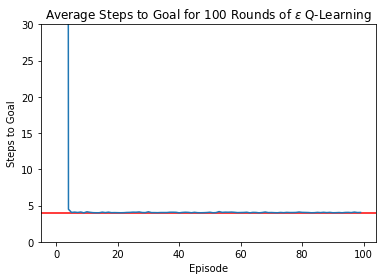

In [ ]:
plt.axhline(y=4, color='red')
plt.plot(q_avg_steps)
plt.ylim(0,30)
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Average Steps to Goal for 100 Rounds of $\epsilon$ Q-Learning")

Text(0.5, 1.0, 'MSE for 100 Rounds of $\\epsilon$ Q-Learning')

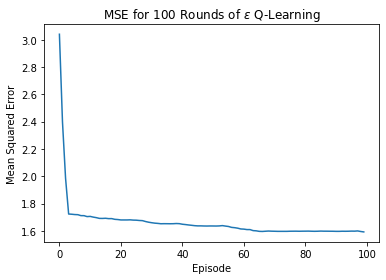

In [ ]:
plt.plot(q_mse)
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error")
plt.title("MSE for 100 Rounds of $\epsilon$ Q-Learning")

# Double Q-Learning

In [ ]:
def double_q_learning(env, epochs, alpha, epsilon, gamma):
  qa_table = np.zeros([env.observation_space.n, env.action_space.n])
  qb_table = np.zeros([env.observation_space.n, env.action_space.n])
  va_table = np.zeros(env.observation_space.n)
  vb_table = np.zeros(env.observation_space.n)
  steps_to_goal = []
  sum_squared_error = []
  for i in range (0,epochs):
    v_error = []
    state = env.reset()
    done = False
    steps = 0 
    while not done:
      q_sum_table = qa_table + qb_table
      if np.random.random() < epsilon:  #Epsilon Greedy Action
        action = env.action_space.sample()
      else:
        action = np.argmax(q_sum_table[state])
      
      next_state, reward, done, info = env.step(action)
      
      if np.random.random() < 0.5:  #Q_A Table Case
        old_q = qa_table[state,action]
        next_action = np.argmax(qa_table[next_state])
        updated_q = (1 - alpha) * old_q + alpha * (reward + gamma * qb_table[next_state,next_action]) #TD Step
        qa_table[state, action] = updated_q
        zip_object = zip(true_v, va_table)
        va_table[state] = reward + gamma * va_table[next_state] #Bellman Equation for V
      else:                          #Q_B Table Case
        old_q = qb_table[state,action]
        next_action = np.argmax(qb_table[next_state])
        updated_q = (1 - alpha) * old_q + alpha * (reward + gamma * qa_table[next_state,next_action]) #TD Step
        qb_table[state, action] = updated_q
        zip_object = zip(true_v, vb_table) 
        vb_table[state] = reward + gamma * vb_table[next_state] #Bellman Equation for V


      state = next_state
      steps += 1
    steps_to_goal.append(steps)
    for v_true, v_current in zip_object:
      v_error.append(v_current - v_true)  #Change in V
    v_error = np.square(v_error)
    v_error = np.sum(v_error)
    sum_squared_error.append(v_error)
  return(sum_squared_error, steps_to_goal, v_table)

In [ ]:
dq_mse = []
dq_avg_steps = []
dq_v_table = []

In [ ]:
for i in range(0,100):
  print("-------- Starting Round: ", (i+1))
  sum_squared_error, steps_to_goal, v_table = double_q_learning(env, 100, alpha, epsilon, gamma)
  dq_mse.append(sum_squared_error)
  dq_avg_steps.append(steps_to_goal)
  dq_v_table.append(v_table)

-------- Starting Round:  1
-------- Starting Round:  2
-------- Starting Round:  3
-------- Starting Round:  4
-------- Starting Round:  5
-------- Starting Round:  6
-------- Starting Round:  7
-------- Starting Round:  8
-------- Starting Round:  9
-------- Starting Round:  10
-------- Starting Round:  11
-------- Starting Round:  12
-------- Starting Round:  13
-------- Starting Round:  14
-------- Starting Round:  15
-------- Starting Round:  16
-------- Starting Round:  17
-------- Starting Round:  18
-------- Starting Round:  19
-------- Starting Round:  20
-------- Starting Round:  21
-------- Starting Round:  22
-------- Starting Round:  23
-------- Starting Round:  24
-------- Starting Round:  25
-------- Starting Round:  26
-------- Starting Round:  27
-------- Starting Round:  28
-------- Starting Round:  29
-------- Starting Round:  30
-------- Starting Round:  31
-------- Starting Round:  32
-------- Starting Round:  33
-------- Starting Round:  34
-------- Starting Round

In [ ]:
dq_mse = [statistics.mean(k) for k in zip(*dq_mse)]
dq_avg_steps = [statistics.mean(k) for k in zip(*dq_avg_steps)]
dq_v_table = np.mean(dq_v_table, axis = 0)

Text(0.5, 1.0, 'Average Steps to Goal for 100 Rounds of Double Q-Learning')

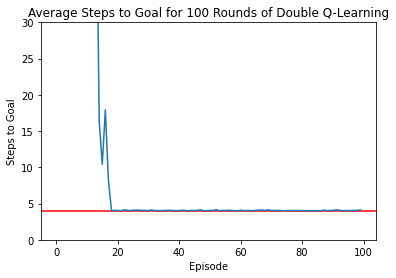

In [ ]:
plt.axhline(y=4, color='red')
plt.plot(dq_avg_steps)
plt.ylim(0,30)
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Average Steps to Goal for 100 Rounds of Double Q-Learning")

Text(0.5, 1.0, 'MSE for 100 Rounds of Double Q-Learning')

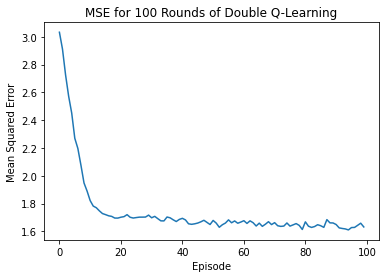

In [ ]:
plt.plot(dq_mse)
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error")
plt.title("MSE for 100 Rounds of Double Q-Learning")

# SARSA(λ)

In [ ]:
def SARSA(env, epochs, alpha, epsilon, gamma, lmbda):
  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  v_table = np.zeros(env.observation_space.n)
  e_table = np.zeros([env.observation_space.n, env.action_space.n]) #Eligibility Trace Table
  steps_to_goal = []
  sum_squared_error = []
  for i in range (0,epochs):
    v_error = []
    state = env.reset()
    done = False
    steps = 0 
    if np.random.random() < epsilon:  #Epsilon Greedy Initial Action
      action = env.action_space.sample()
    else:
      action = np.argmax(q_table[state])

    while not done:
      next_state, reward, done, info = env.step(action)
      if np.random.random() < epsilon:  #Epsilon Greedy (s', a')
        next_action = env.action_space.sample()
      else:
        next_action = np.argmax(q_table[next_state])

      delta = reward + gamma * q_table[next_state, next_action] - q_table[state, action]
      e_table[state,action] = e_table[state,action] + 1 #Accumulating Eligibility Traces

      q_table = q_table + (alpha * delta) * e_table
      e_table = (gamma * lmbda) * e_table
      v_table[state] = reward + gamma * v_table[next_state] #Bellman Equation for V

      state = next_state
      action = next_action
      steps += 1
  
    steps_to_goal.append(steps)
    zip_object = zip(true_v, v_table)
    for v_true, v_current in zip_object:
      v_error.append(v_current - v_true)  #Change in V
    v_error = np.square(v_error)
    v_error = np.sum(v_error)
    sum_squared_error.append(v_error)
  return(sum_squared_error, steps_to_goal, v_table)

In [ ]:
sarsa_mse = []
sarsa_avg_steps = []
sarsa_v_table = []

In [ ]:
for i in range(0,100):
  print("-------- Starting Round: ", (i+1))
  sum_squared_error, steps_to_goal, v_table = SARSA(env, 100, alpha, epsilon, gamma, 0.9) #lambda = 0.9
  sarsa_mse.append(sum_squared_error)
  sarsa_avg_steps.append(steps_to_goal)
  sarsa_v_table.append(v_table)

-------- Starting Round:  1
-------- Starting Round:  2
-------- Starting Round:  3
-------- Starting Round:  4
-------- Starting Round:  5
-------- Starting Round:  6
-------- Starting Round:  7
-------- Starting Round:  8
-------- Starting Round:  9
-------- Starting Round:  10
-------- Starting Round:  11
-------- Starting Round:  12
-------- Starting Round:  13
-------- Starting Round:  14
-------- Starting Round:  15
-------- Starting Round:  16
-------- Starting Round:  17
-------- Starting Round:  18
-------- Starting Round:  19
-------- Starting Round:  20
-------- Starting Round:  21
-------- Starting Round:  22
-------- Starting Round:  23
-------- Starting Round:  24
-------- Starting Round:  25
-------- Starting Round:  26
-------- Starting Round:  27
-------- Starting Round:  28
-------- Starting Round:  29
-------- Starting Round:  30
-------- Starting Round:  31
-------- Starting Round:  32
-------- Starting Round:  33
-------- Starting Round:  34
-------- Starting Round

In [ ]:
sarsa_mse = [statistics.mean(k) for k in zip(*sarsa_mse)]
sarsa_avg_steps = [statistics.mean(k) for k in zip(*sarsa_avg_steps)]
sarsa_v_table = np.mean(sarsa_v_table, axis = 0)

Text(0.5, 1.0, 'Average Steps to Goal for 100 Rounds of SARSA($\\lambda$)')

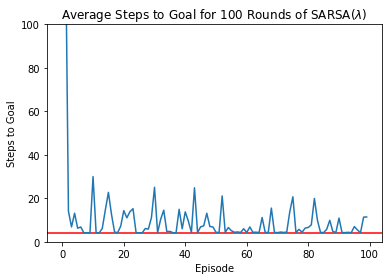

In [ ]:
plt.axhline(y=4, color='red')
plt.plot(sarsa_avg_steps)
plt.ylim(0,100)
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Average Steps to Goal for 100 Rounds of SARSA($\lambda$)")

Text(0.5, 1.0, 'MSE for 100 Rounds of SARSA($\\lambda$)')

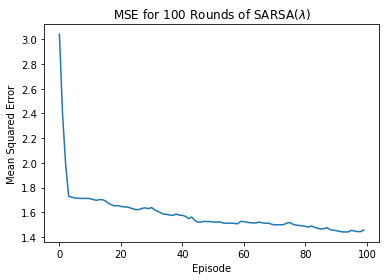

In [ ]:
plt.plot(sarsa_mse)
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error")
plt.title("MSE for 100 Rounds of SARSA($\lambda$)")

# Comparison


Text(0.5, 1.0, 'Average Steps to Goal for 100 Trials of TD Learning')

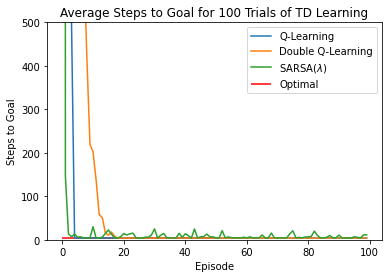

In [ ]:
fig, ax = plt.subplots()
opt = ax.hlines(4, xmin=0, xmax=50, color='red', label='Optimal')
exp1, = ax.plot(q_avg_steps, label='Q-Learning')
exp2, = ax.plot(dq_avg_steps, label='Double Q-Learning')
exp3, = ax.plot(sarsa_avg_steps, label='SARSA($\lambda$)')
ax.legend(handles=[exp1,exp2,exp3, opt])
ax.set_ylabel("Steps to Goal")
ax.set_xlabel("Episode")
plt.ylim(0,500)
ax.set_title("Average Steps to Goal for 100 Trials of TD Learning")

Text(0.5, 1.0, 'MSE for 100 Trials of TD Learning')

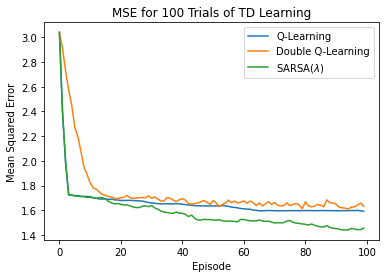

In [ ]:
fig, ax = plt.subplots()
exp1, = ax.plot(q_mse, label='Q-Learning')
exp2, = ax.plot(dq_mse, label='Double Q-Learning')
exp3, = ax.plot(sarsa_mse, label='SARSA($\lambda$)')
ax.legend(handles=[exp1,exp2,exp3])
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Episode")
ax.set_title("MSE for 100 Trials of TD Learning")

In [ ]:
# Can be modified to find convergent v-table, but inaccurate as some states go unexplored.
# v_tables = []
# step_curves = []
# avg_v = np.zeros(env.observation_space.n)
# avg_steps = []
# not_converged = True

# while not_converged:
#   gradient_v = []
#   v_table, steps_to_goal = ep_q_learning(env, 50, alpha, epsilon, gamma)
#   v_tables.append(v_table)
#   step_curves.append(steps_to_goal)

#   new_avg_v = [statistics.mean(k) for k in zip(*v_tables)]
#   zip_object = zip(new_avg_v, avg_v)
#   for v_new, v_old in zip_object:
#     gradient_v.append(v_new - v_old)  #Change in V
#   avg_v = new_avg_v
#   max_gradient = np.max(gradient_v)
#   print(max_gradient)
#   if max_gradient < 0.05: #Tolerance Value for Convergence
#     not_converged = False

In [ ]:
q_v_table

array([0.4999168, 0.       , 0.       , 0.64     , 0.118784 , 0.01     ,
       0.8      , 1.       , 0.       ])

In [ ]:
dq_v_table

In [ ]:
sarsa_v_table

array([0.4888576 , 0.1781038 , 0.05302976, 0.50529901, 0.31623875,
       0.1056    , 0.67987143, 0.96707614, 0.        ])